In [1]:
# standard library dependencies
from collections import Counter

# external dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

# local dependencies
from classification_preparation import (
    load_dataset_with_engineered_features,
    return_data_to_predict_at_month,
    prepare_to_predict_feature,
    split_into_training_validating_testing
)

from ensemble_classifiers import (
    GB_classifier,
    RF_classifier,
    NB_classifier
)

from create_violin_plots import create_violin_plots_model_acc

In [2]:
all_data = load_dataset_with_engineered_features(
    "data",
    must_have_substring="cleaned_",
    verbose=True
)


cleaned_01-2018.txt: (6493, 26)

cleaned_01-2019.txt: (9707, 26)

cleaned_02-2018.txt: (6733, 26)

cleaned_02-2019.txt: (9923, 26)

cleaned_03-2018.txt: (7015, 26)

cleaned_04-2018.txt: (7328, 26)

cleaned_05-2018.txt: (7678, 26)

cleaned_06-2018.txt: (7944, 26)

cleaned_07-2018.txt: (8209, 26)

cleaned_08-2018.txt: (8443, 26)

cleaned_09-2018.txt: (8652, 26)

cleaned_10-2018.txt: (8940, 26)

cleaned_11-2018.txt: (9218, 26)

cleaned_12-2018.txt: (9440, 26)

cleaned_2019-03.txt: (10171, 26)

cleaned_2019-04.txt: (10518, 26)

cleaned_2019-05.txt: (10829, 26)

cleaned_2019-06.txt: (11124, 26)

cleaned_2019-07.txt: (11388, 26)

cleaned_2019-08.txt: (11668, 26)

cleaned_2019-09.txt: (11986, 26)

finished compiling 21 datasets
loaded 21 datasets; adding engineered features
added engineered features to all datasets


In [3]:
print(all_data["cleaned_2019-09.txt"].tail())

               DR Speciality  Payment Method #5  Payment Method #4  \
Patient ID                                                           
Patient_12146            0.0                0.0                0.0   
Patient_12147            0.0                1.0                0.0   
Patient_12148            0.0                0.0                0.0   
Patient_12149            0.0                0.0                0.0   
Patient_12150            0.0                0.0                0.0   

               DR PROVINCE  Dosage  DR ID  Payment Method #1  Status Group  \
Patient ID                                                                   
Patient_12146          0.0     0.0    0.0                0.0           0.0   
Patient_12147          4.0     0.0  835.0                0.0           3.0   
Patient_12148          4.0     0.0  429.0                0.0           2.0   
Patient_12149          0.0     0.0    0.0                0.0           0.0   
Patient_12150          0.0     0.0    0.0

In [4]:
useable_data = return_data_to_predict_at_month(
    all_data,
    "cleaned_2019-08.txt",
    verbose=True
)

100%|████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 12.82it/s]


11388 useable patients


In [5]:
useable_data.columns

Index(['delta_DR Speciality', 'delta_Payment Method #5',
       'delta_Payment Method #4', 'delta_DR PROVINCE', 'delta_Dosage',
       'delta_DR ID', 'delta_Payment Method #1', 'delta_Status Group',
       'delta_Status Description', 'delta_Frequency', 'delta_Diagnosis ID',
       'delta_Payment Method #3', 'delta_Biologic Line of Therapy',
       'delta_Status', 'delta_Gender ID', 'delta_Payment Method #2',
       'delta_Patient Receiving Free Drug', 'delta_Case State',
       'delta_Age Range', 'delta_Day Enrollment Received',
       'delta_Day Enrollment Completed', 'delta_State Change Day',
       'delta_On Drug Start Day', 'delta_Last On Drug Day',
       'delta_Re-Engagement Day', 'delta_Re-Engagement On Drug Start Day',
       'delta_Enrollment Time', 'delta_On Drug Time',
       'delta_# of Payment Methods', 'delta_DosageFrequencyIndex',
       'delta_Number of Months', 'DR Speciality', 'Payment Method #5',
       'Payment Method #4', 'DR PROVINCE', 'Dosage', 'DR ID',
       'P

In [6]:
features_df, feature_to_predict = prepare_to_predict_feature(
    "Patient Receiving Free Drug",
    useable_data,
    verbose=True
)
labels = list(set(feature_to_predict.values.tolist()))

In [7]:
all_splits_dict = split_into_training_validating_testing(
    features_df,
    feature_to_predict,
    verbose=True
)

# keys of dictionaries in all_splits_dict
#"X train",
#"X validate", 
#"X test", 
#"y train", 
#"y validate", 
#"y test"

dimensions of testing dataset: (1709, 60), (1709,)
dimensions of validating dataset: (1936, 60), (1936,)
dimensions of training dataset: (7743, 60), (7743,)
dimensions of original dataset: (11388, 60)


In [8]:
for splits_dict in all_splits_dict:
    # result is a dict of:
    # "Model Confusion Matrix"
    # "Model Accuracy"
    # "Baseline Confusion Matrix"
    # "Baseline Accuracy"
    # "Classifier"
    result = RF_classifier(
        splits_dict["X train"],
        splits_dict["y train"],
        splits_dict["X test"],
        splits_dict["y test"],
        labels,
        return_baseline_cm = True
    )


In [9]:
print(result["Model Accuracy"], result["Baseline Accuracy"])
print("\n")
print(result["Model Confusion Matrix"])
print("\n")
print(result["Baseline Confusion Matrix"])


0.8221181977764774 0.7226448215330603


[[1405    0]
 [ 304    0]]


[[1176  229]
 [ 245   59]]


In [10]:
all_splits_dict = split_into_training_validating_testing(
    features_df,
    feature_to_predict,
    verbose=True,
    use_strat_splits=True
)

# keys of dictionaries in all_splits_dict
#"X train",
#"X validate", 
#"X test", 
#"y train", 
#"y validate", 
#"y test"

In [11]:
num_classes = len(np.unique(feature_to_predict))
RF_model_accs, RF_model_cm = [], np.zeros((num_classes,num_classes))
GB_model_accs, GB_model_cm = [], np.zeros((num_classes,num_classes))
NB_model_accs, NB_model_cm = [], np.zeros((num_classes,num_classes))
baseline_accs = []
baseline_model_cm = np.zeros((num_classes,num_classes))

RF_outcomes = pd.DataFrame(np.zeros((10,2)), columns=["Model Acc", "Baseline Acc"])
GB_outcomes = pd.DataFrame(np.zeros((10,2)), columns=["Model Acc", "Baseline Acc"])
NB_outcomes = pd.DataFrame(np.zeros((10,2)), columns=["Model Acc", "Baseline Acc"])


for model, acc_list, avg_cm, name, df in zip(
    [RF_classifier, GB_classifier, NB_classifier],
    [RF_model_accs, GB_model_accs, NB_model_accs],
    [RF_model_cm, GB_model_cm, NB_model_cm],
    ["RF","GB","NB"],
    [RF_outcomes, GB_outcomes, NB_outcomes]):
    print(f"========{name}========")
    for e, splits_dict in enumerate(all_splits_dict):
        # result is a dict of:
        # "Model Confusion Matrix"
        # "Model Accuracy"
        # "Baseline Confusion Matrix"
        # "Baseline Accuracy"
        # "Classifier"
        result = model(
            splits_dict["X train"],
            splits_dict["y train"],
            splits_dict["X test"],
            splits_dict["y test"],
            labels,
            return_baseline_cm = True
        )
        print( result["Model Accuracy"], result["Baseline Accuracy"] )
        acc_list.append( result["Model Accuracy"] )
        acc_list.append( result["Baseline Accuracy"] )
        df.loc[e, "Model Acc"] = result["Model Accuracy"]
        df.loc[e, "Baseline Acc"] = result["Baseline Accuracy"]
        #if e == 0:
        #    avg_cm = (result["Model Confusion Matrix"] / 10)
        #else:
            #pass
        avg_cm += (result["Model Confusion Matrix"] / 10)

        #if baseline_model_cm is None:
        #    baseline_model_cm = (result["Baseline Confusion Matrix"] / 30)
        #else: 
            #pass
        baseline_accs.append(result["Baseline Accuracy"])
        baseline_model_cm += (result["Baseline Confusion Matrix"] / 30)
    print(avg_cm)

========RF========
0.8221181977764774 0.7249853715623171
0.8221181977764774 0.722059684025746
0.8227033352837917 0.7214745465184318
0.8221181977764774 0.7144528964306612
0.8227033352837917 0.713867758923347
0.8221181977764774 0.7132826214160327
0.8221181977764774 0.7009947337624342
0.8221181977764774 0.7080163838502048
0.8221181977764774 0.7144528964306612
0.8215330602691633 0.7039204212990052
[[1.4049e+03 1.0000e-01]
 [3.0380e+02 2.0000e-01]]
========GB========
0.8736102984201287 0.7015798712697484
0.8724400234055003 0.7109420713867759
0.874195435927443 0.7267407840842598
0.8671737858396723 0.708601521357519
0.8660035108250439 0.695143358689292
0.863662960795787 0.716793446459918
0.8712697483908719 0.7267407840842598
0.8747805734347571 0.6998244587478057
0.8619075482738443 0.7103569338794616
0.8736102984201287 0.716793446459918
[[1338.    67. ]
 [ 155.4  148.6]]
========NB========
0.8215330602691633 0.7214745465184318
0.8168519602106495 0.7156231714452896
0.8174370977179637 0.72557050

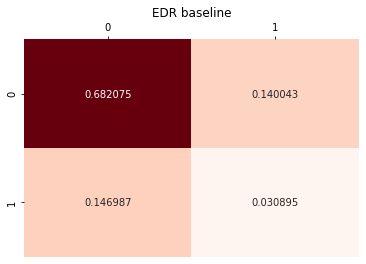

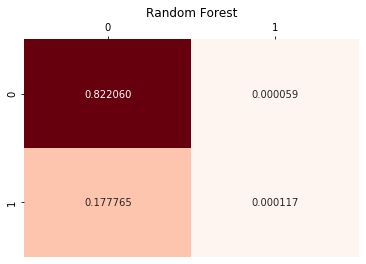

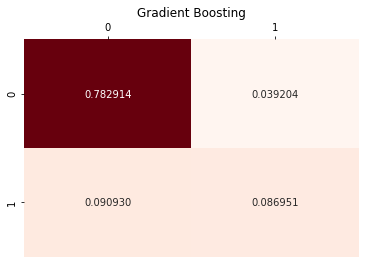

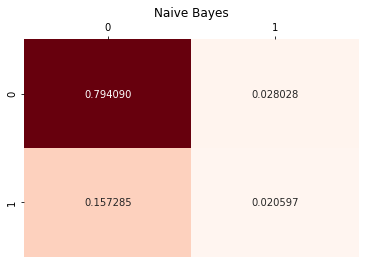

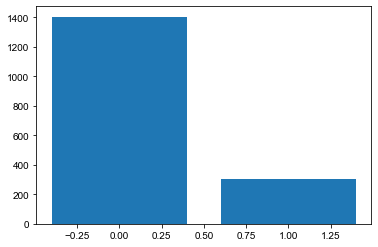

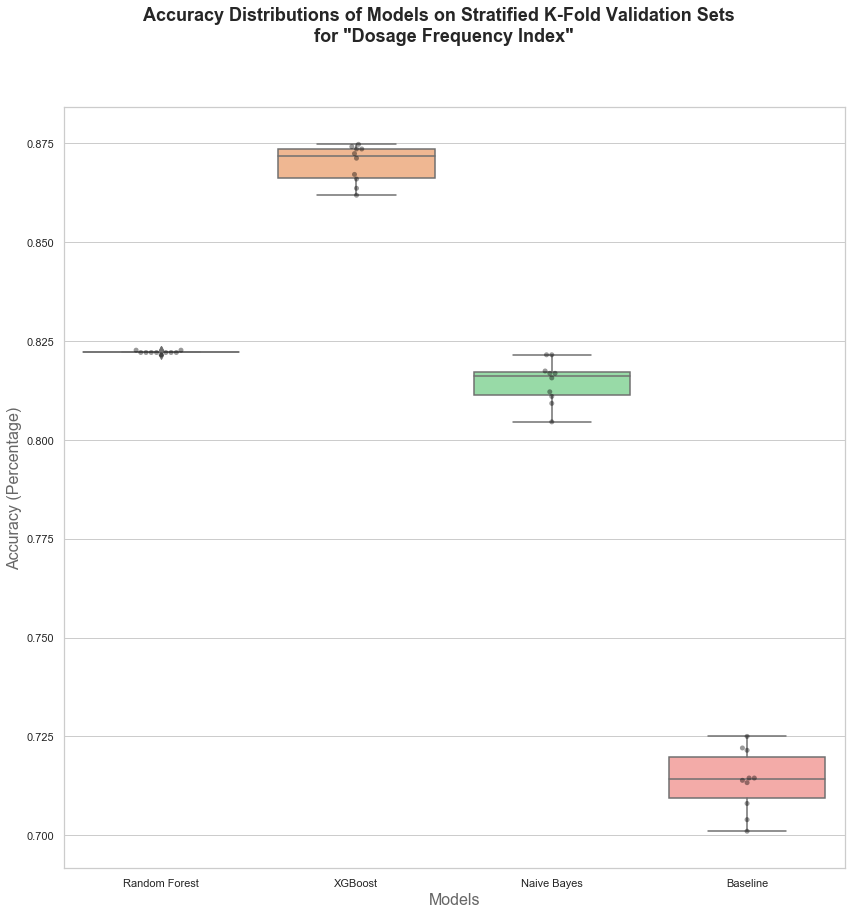

In [12]:
for e, (cm, name) in enumerate(
    zip([baseline_model_cm, RF_model_cm, GB_model_cm, NB_model_cm], 
        ["EDR baseline", "Random Forest", "Gradient Boosting", "Naive Bayes"])):
    cm_norm = cm / cm.sum()
    ax = sns.heatmap(cm_norm, cmap="Reds", annot=True, fmt="f", cbar=False)
    ax.xaxis.set_ticks_position('top')
    ax.set_title(name)
    plt.show()

plt.bar(x=np.arange(cm.shape[0]), height=cm.sum(axis=1))

create_violin_plots_model_acc(RF_outcomes.values, GB_outcomes.values, NB_outcomes.values, baseline_accs)